This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/humanoids.html).  I recommend having both windows open, side-by-side!


In [1]:
from functools import partial
import scipy as sp
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    AddUnitQuaternionConstraintOnPlant,
    AutoDiffXd,
    DiagramBuilder,
    DiscreteTimeLinearQuadraticRegulator,
    ExtractGradient,
    ExtractValue,
    InitializeAutoDiff,
    JacobianWrtVariable,
    JointIndex,
    MathematicalProgram,
    MeshcatVisualizer,
    MultibodyPlant,
    OrientationConstraint,
    Parser,
    PidController,
    PiecewisePolynomial,
    PositionConstraint,
    RigidTransform,
    RotationMatrix,
    Simulator,
    SnoptSolver,
    Solve,
    StartMeshcat,
    eq,
    namedview,
    DirectCollocation,
    PiecewisePolynomial,
    FirstOrderTaylorApproximation,
    TrajectorySource,
    MultibodyPositionToGeometryPose,

)

from underactuated import ConfigureParser, running_as_notebook



import math
import matplotlib.pyplot as plt
import mpld3
import numpy as np
import pydot
from IPython.display import HTML, display, SVG
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    LeafSystem,
    LinearSystem,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    ModelVisualizer,
    Parser,
    LogVectorOutput,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    SymbolicVectorSystem,
    Variable,
    WrapToSystem,
    FrameId
)
from pydrake.common import FindResourceOrThrow

from pydrake.all import MultibodyPlant, RevoluteJoint, RigidTransform, UnitInertia, RigidBody
from pydrake.multibody.tree import SpatialInertia


from pydrake.examples import (
    QuadrotorGeometry,
    QuadrotorPlant,
    StabilizingLQRController,
)
from pydrake.solvers import MathematicalProgram, Solve
from pydrake.geometry import Cylinder

from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

if running_as_notebook:
    mpld3.enable_notebook()

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://0561bb78-2b86-4280-965f-ef37e93411a8.deepnoteproject.com/7000/


In [3]:
rod_link = """ 
    <link name="rod0">

        <inertial>
        <origin xyz="0 0 -1/2" />
        <mass value=".225" />
        </inertial>

    <!-- Visual Component -->

        <visual>
        <origin xyz="0 0 0.5" rpy="0 0 0" />
        <geometry>
            <cylinder length="1.0" radius=".01" />
        </geometry>
        <material>
            <color rgba="1 0 0 1" />
        </material>
        </visual>
        <collision>
            <origin xyz="0 0 0.5" rpy="0 0 0" />
            <geometry>
                <cylinder length="1.0" radius=".01" />
            </geometry>
        </collision>

    </link>
    """

base_link = """<link name="base_link">
    <inertial>
      <mass value="0.775"/>
      <origin xyz="0 0 0"/>
      <inertia ixx="0.0015" ixy="0.0" ixz="0.0" iyy="0.0025" iyz="0.0" izz="0.0035"/>
    </inertial>
    <visual>
      <origin rpy="1.570796 0 0" xyz="0 0 0"/>
      <geometry>
        <mesh filename="package://drake_models/skydio_2/skydio_2_1000_poly.obj" scale=".00254"/>
      </geometry>
    </visual>
    <collision>
      <origin rpy="0 0 0" xyz="0 0 0"/>
      <geometry>
        <box size=".36 .4 .06"/>
      </geometry>
    </collision>
</link>"""

r_joint = """
  <joint name="theta" type="revolute">
    <parent link="base_link" />
    <child link="rod0" />
    <axis xyz="0 -1 0" />
    <origin xyz="0 0 0"/>
    <limit lower="0" upper="6.28318530718" />
  </joint>
"""

quadrotor_urdf = f"""<?xml version="1.0"?>
<robot name="quadrotor">
  {base_link}
  {rod_link}
  {r_joint}
</robot>"""

In [4]:
import numpy as np
from pydrake.all import (
    DiagramBuilder,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    BodyIndex
)
import pydrake.math
# from pydrake.math import SpatialInertia
from pydrake.examples import QuadrotorPlant

from underactuated.scenarios import AddFloatingRpyJoint


def MakeMultibodyQuadrotor():
    builder = DiagramBuilder()
    # The MultibodyPlant handles f=ma, but doesn't know about propellers.
    drone, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step = 0.0)
    parser = Parser(drone)
    ConfigureParser(parser)
    (model_instance, ) = parser.AddModelsFromString(quadrotor_urdf, "urdf")
    # scene_graph = builder.AddSystem(SceneGraph())
    print(builder)
    # AddMultiBodyPlantToBuilder(
    #      builder, drone.get_output_port(), scene_graph
    #  )
    meshcat.Delete()
    meshcat.ResetRenderMode()
    meshcat.SetProperty("/Background", "visible", False)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

    # By default the multibody has a quaternion floating base.  To match
    # QuadrotorPlant, we can manually add a FloatingRollPitchYaw joint. We set
    # `use_ball_rpy` to false because the BallRpyJoint uses angular velocities
    # instead of ṙ, ṗ, ẏ.
    AddFloatingRpyJoint(
        drone,
        drone.GetFrameByName("base_link"),
        model_instance,
        use_ball_rpy=False,
    )

    drone.Finalize()

    # Now we can add in propellers as an external force on the MultibodyPlant.
    body_index = drone.GetBodyByName("base_link").index()
    # Default parameters from quadrotor_plant.cc:
    L = 0.15  # Length of the arms (m).
    kF = 1.0  # Force input constant.
    kM = 0.0245  # Moment input constant.

    # Note: Rotors 0 and 2 rotate one way and rotors 1 and 3 rotate the other.
    prop_info = [
        PropellerInfo(body_index, RigidTransform([L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, L, 0]), kF, -kM),
        PropellerInfo(body_index, RigidTransform([-L, 0, 0]), kF, kM),
        PropellerInfo(body_index, RigidTransform([0, -L, 0]), kF, -kM),
    ]
    propellers = builder.AddSystem(Propeller(prop_info))
    type(Propeller(prop_info))
    builder.Connect(
        propellers.get_output_port(),
        drone.get_applied_spatial_force_input_port(),
    )
    builder.Connect(
        drone.get_body_poses_output_port(),
        propellers.get_body_poses_input_port(),
    )
    builder.ExportInput(propellers.get_command_input_port(), "u")
    builder.ExportOutput(drone.get_state_output_port(),"outputport")

    # # Edited here
    # diagram_context = diagram.CreateDefaultContext()
    # g = 9.81 # m/s^2
    # mass = 1
    # weight = mass*g
    # Q = np.diag([10, 10, 10, 1, 1, 1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01])  # state cost matrix
    # R = np.diag([1, 1, 1, 1])  # input cost matrix
    # diagram.get_input_port().FixValue(diagram_context,[weight/4,weight/4,weight/4,weight/4])
    # diagram_context.SetContinuousState([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
    # controller = LinearQuadraticRegulator(diagram, diagram_context, Q, R)



    # builder.AddNamedSystem("lqr", controller)

    # print("drone input port size:", drone.get_input_port(0).size())
    # print("drone output port size:", drone.get_output_port(0).size())
    # print("controller input port size:", controller.get_input_port(0).size())
    # print("controller output port size:", controller.get_output_port(0).size())


    # builder.Connect(drone.get_state_output_port(), controller.get_input_port(0))
    # builder.Connect(controller.get_output_port(0),
    #             drone.get_actuation_input_port())


    # meshcat.Delete()
    # visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # visualizer.set_name("visualizer")

    return builder.Build(), drone, parser, builder, scene_graph
    #return builder.Build(), plant



# # This test demonstrates that the MultibodyPlant version has identical dynamics
# # to the QuadrotorPlant version (except that the state variables are permuted).
# # TODO(russt): Move this to Drake as a unit test.
# def MultibodyQuadrotorExample():
#     mbp_plant, mbp = MakeMultibodyQuadrotor()

#     hand_derived_plant = QuadrotorPlant()

#     # Compare the dynamics at a handful of states.
#     mbp_plant_context = mbp_plant.CreateDefaultContext()
#     mbp_context = mbp.GetMyContextFromRoot(mbp_plant_context)
#     hand_derived_context = hand_derived_plant.CreateDefaultContext()

#     # Permute mbp <=> hand_derived states.
#     P = np.array(
#         [
#             [1, 0, 0, 0, 0, 0],
#             [0, 1, 0, 0, 0, 0],
#             [0, 0, 1, 0, 0, 0],
#             [0, 0, 0, 0, 0, 1],
#             [0, 0, 0, 0, 1, 0],
#             [0, 0, 0, 1, 0, 0],
#         ]
#     )
#     PP = np.block([[P, np.zeros((6, 6))], [np.zeros((6, 6)), P]])

#     rng = np.random.default_rng(seed=1037)
#     for i in range(5):
#         u = rng.random((4,))
#         mbp_x = rng.random((12,)) #25
#         mbp_plant.get_input_port().FixValue(mbp_plant_context, u)
#         mbp_context.SetContinuousState(mbp_x)
#         mbp_xdot = mbp_plant.EvalTimeDerivatives(
#             mbp_plant_context
#         ).CopyToVector()

#         hand_derived_x = PP @ mbp_x
#         hand_derived_plant.get_input_port().FixValue(hand_derived_context, u)
#         hand_derived_context.SetContinuousState(hand_derived_x)
#         hand_derived_xdot = (
#             PP
#             @ hand_derived_plant.EvalTimeDerivatives(
#                 hand_derived_context
#             ).CopyToVector()
#         )

#         assert np.allclose(
#             mbp_xdot, hand_derived_xdot
#         ), f"\nmbp\t\t = {mbp_xdot}\nhand_derived\t = {hand_derived_xdot}"


# MakeMultibodyQuadrotor()
(drone_diagram, drone, parser, builder, scene_graph)=MakeMultibodyQuadrotor()
#(drone_diagram,drone, parser, builder)=MakeMultibodyQuadrotor()

context=drone_diagram.CreateDefaultContext()
drone_diagram.ForcedPublish(context)


# # From here
# if diagram:
#     diagram_context = diagram.CreateDefaultContext()
#     g = 9.81 # m/s^2
#     mass = 1
#     weight = mass*g
#     Q = np.diag([10, 10, 10, 1, 1, 1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01, 0.01])  # state cost matrix
#     R = np.diag([1, 1, 1, 1])  # input cost matrix
#     diagram.get_input_port().FixValue(diagram_context,[weight/4,weight/4,weight/4,weight/4])
#     diagram_context.SetContinuousState([0,0,0,0,0,0,0,0,0,0,0,0,0,0])
#     controller = LinearQuadraticRegulator(diagram, diagram_context, Q, R)

#     builder.AddNamedSystem("lqr", controller)

#     builder.Connect(drone.get_state_output_port(), controller.get_input_port(0))
#     builder.Connect(controller.get_output_port(0),
#                 drone.get_actuation_input_port())


#     meshcat.Delete()
#     visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
#     visualizer.set_name("visualizer")



# Get the mass information for the base_link
base_link = drone.GetBodyByName("base_link")
base_link_mass = base_link.default_mass()
print(f"base_link mass: {base_link_mass}")

# Get the mass information for the rod0 link
rod0_link = drone.GetBodyByName("rod0")
rod0_link_mass = rod0_link.default_mass()
print(f"rod0 link mass: {rod0_link_mass}")

PositionView = namedview(
        "States",
        drone.GetStateNames(
            drone.GetModelInstanceByName("quadrotor")))

# Get the state names from the named view
state_names = PositionView._fields

# Print the state names
print("State names: ", state_names)

base_link mass: 0.775
rod0 link mass: 0.225
State names:  ('x_x', 'y_x', 'z_x', 'rz_q', 'ry_q', 'rx_q', 'theta_q', 'x_v', 'y_v', 'z_v', 'rz_w', 'ry_w', 'rx_w', 'theta_w')


# MPC  with Direct Shooting

In [23]:
# time discretization step
h = 0.5
quadrotor, mbp, _, _, _ = MakeMultibodyQuadrotor()
context = quadrotor.CreateDefaultContext()
g = 9.81 # m/s^2
mass = 1
weight = mass*g
quadrotor.get_input_port().FixValue(context, [weight/4,weight/4,weight/4,weight/4])
coeffs = FirstOrderTaylorApproximation(quadrotor, context)
Act = coeffs.A()
Bct = coeffs.B()
# discretize using explicit Euler
# x[n+1] = x[n] + h (Act x[n] + Bct u[n])
#        = (I + h Act) x[n] + h Bct u[n]
A = np.eye(Act.shape[0]) + h * Act
B = h * Bct

# objective function
Q = np.diag([10,10,10, 10, 10, 10, 10, 1, 1, 1, 1, 1, 1, 1])  # state cost matrix
R = np.diag([1, 1, 1, 1])  # input cost matrix
# QN = np.array([[3, 0,0,0,0,0,0,0,0,0,0,0,0,0], [0,2,0,0,0,0,0,0,0,0,0,0,0,0], ])
QN = 3*np.eye(14)

# initial state
x0 = initial_state = np.array([0.5,0.6,0.9,0,0,0,3*(np.pi)/4,0,0,0,0,0,0,0])

# optimal feedback gain and cost-to-go matrix
K, S = DiscreteTimeLinearQuadraticRegulator(A, B, Q, R)

# cost to go from state x0
J_star_inf = x0.dot(S).dot(x0)

In [20]:
# efficient computation of the matrix Ab
def get_Ab(A, N):
    # Ab is defined only for N >= 1
    assert N >= 1

    # number of states
    p = A.shape[0]

    # initialize matrix with all zeros
    Ab = np.zeros((p * N, p))

    # put A matrix in top block
    rows = slice(0, p)  # equivalent to :p
    Ab[rows, :] = A

    # loop over the block-rows
    for n in range(1, N):
        # move the row indices one block down
        prev_rows = rows
        rows = slice(
            prev_rows.start + p, prev_rows.stop + p
        )  # equivalent to n*p:(n+1)*p

        # premultiply previous block by A
        # place the result in this block
        Ab[rows, :] = A.dot(Ab[prev_rows, :])

    return Ab


# efficient computation of the matrix Bb
def get_Bb(A, B, N):
    # Bb is defined only for N >= 1
    assert N >= 1

    # number of states and inputs
    p, q = B.shape

    # initialize matrix with all zeros
    Bb = np.zeros((p * N, q * N))

    # put B matrix in top-left block
    rows = slice(0, p)  # equivalent to :p
    Bb[rows, :q] = B

    # loop over the block-rows
    for n in range(1, N):
        # move the row indices one block down
        prev_rows = rows
        rows = slice(
            prev_rows.start + p, prev_rows.stop + p
        )  # equivalent to n*p:(n+1)*p

        # premultiply first block from previous block-row by A
        # place the result as first block of this block-row
        Bb[rows, :q] = A.dot(Bb[prev_rows, :q])

        # shift the rest of previous block-row one block forward and
        # place it in the current block-row
        Bb[rows, q : (n + 1) * q] = Bb[prev_rows, : n * q]

    return Bb

In [21]:
# function that given the system state x0 (together with:
# the dynamical system matrices A, B; the objective weights
# Q, R, QN; and the controller horizon N) returns the cost
# to go of the finite-horizon LQR using direct shooting
def get_J_star_N_shooting(A, B, Q, R, QN, N, x0):
    # condensed dynamic equations
    state_trajectory = [x0]
    Ab = get_Ab(A, N)
    Bb = get_Bb(A, B, N)

    # weight block matrices
    Qb = sp.linalg.block_diag(*([Q] * (N - 1) + [QN]))
    Rb = sp.linalg.block_diag(*([R] * N))
    Hb = Rb + Bb.T.dot(Qb).dot(Bb)

    # solve for the optimal ub inputs
    ub = np.linalg.solve(Hb, -Bb.T.dot(Qb).dot(Ab).dot(x0))

    # plug optimal Ub in J to get the cost to go
    J = (
        x0.T.dot(Q + Ab.T.dot(Qb).dot(Ab)).dot(x0)
        + 2 * x0.T.dot(Ab.T).dot(Qb).dot(Bb).dot(ub)
        + ub.T.dot(Hb).dot(ub)
    )
    #print("ub = ", ub)
    return [J, ub]

[-1.48414667e-01  4.44227294e-02  5.72241177e-01  4.17524344e-01
  3.49397135e-01 -1.43566569e+00 -3.18685126e+00 -2.14843636e+00
 -2.00105006e+01 -1.50860522e+01 -1.43712252e+01 -1.49898544e+01
  3.77534553e+01  3.28952860e+01  3.53664485e+01  3.31756868e+01
 -1.33462580e+01 -1.22179212e+01 -1.47804910e+01 -1.21350262e+01
 -3.54749337e+00 -3.52747558e+00 -3.11421135e+00 -3.58246941e+00
 -4.05582709e+00 -3.42841182e+00 -3.41637424e+00 -3.48727483e+00
  2.45483344e+00  2.29807091e+00  2.62375588e+00  2.27974857e+00
  7.62503800e-01  7.11030648e-01  6.46626908e-01  7.16170109e-01
 -2.37006050e-01 -2.66683344e-01 -3.62432010e-01 -2.59728480e-01
  1.20476379e-02 -1.61474975e-02 -2.72661120e-02 -1.41481688e-02
  5.89944456e-02  5.99296122e-02  7.26969359e-02  5.90961303e-02
 -4.93345887e-02 -3.40573138e-02 -2.95455372e-02 -3.49784297e-02
  9.34335141e-03  1.12578329e-02  1.73571227e-02  1.10282550e-02
 -5.96203468e-03 -5.75630534e-03 -7.08248070e-03 -5.62751881e-03
  4.45813131e-04 -1.18757

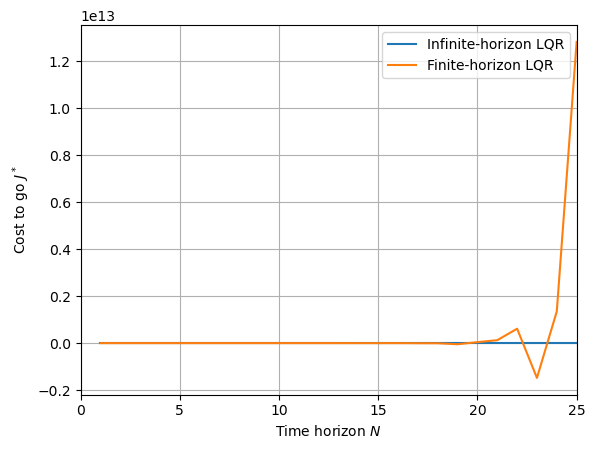

In [24]:
# function that plots the finite-horizon cost to go
# as a function of the horizon length N
# and compares it to the infinite-horizon solution
# J_star_N is a list of floats: cost to go from N = 1 to N = N_max
# J_star_inf is a float: infinite-horizon cost to go
def plot_J_star(J_star_N, J_star_inf):
    # maximum length of the horizon
    N_max = len(J_star_N)

    # infinite-horizon cost to go
    plt.plot(range(1, N_max + 1), [J_star_inf] * N_max, label="Infinite-horizon LQR")

    # finite-horizon cost to go
    plt.plot(range(1, N_max + 1), J_star_N, label="Finite-horizon LQR")

    # misc settings
    plt.xlim(0, N_max)
    plt.xlabel(r"Time horizon $N$")
    plt.ylabel(r"Cost to go $J^*$")
    plt.grid(True)
    plt.legend()


x0 = np.array([0.5, 0.5, 0.5, 0, 0, 0, 3 * (np.pi) / 4, 0, 0, 0, 0, 0, 0, 0])
state = np.zeros((14,)) - x0
traj = [state]
J_star_N_shooting = np.array([])
U = np.array([[0, 0, 0, 0]])
for i in range(25):
    # get cost to go as a function of N
    N_max = 25
    #for n in range(1, N_max + 1):
    output = get_J_star_N_shooting(A, B, Q, R, QN, N_max, state)
    J_star_N_shooting = np.append(J_star_N_shooting, output[0])
    U = np.append(U, [output[1][:4]])
    print(output[1])
    state = np.matmul(A, state) + np.matmul(B, output[1][:4].T)
    traj.append(state)

# # get cost to go as a function of N
# N_max = 25
# J_star_N_shooting = [
#     get_J_star_N_shooting(A, B, Q, R, QN, N, state)[0] for N in range(1, N_max + 1)
# ]
# K, S = DiscreteTimeLinearQuadraticRegulator(A, B, Q, R)

# cost to go from state x0
J_star_inf = x0.dot(S).dot(x0)
print(J_star_inf)
print("J Star N Shooting", J_star_N_shooting)
# # plot finite horizon vs infinite horizon
# print(J_star_N_shooting)
plt.figure()
plot_J_star(J_star_N_shooting, J_star_inf)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0561bb78-2b86-4280-965f-ef37e93411a8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>